# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from math import pi
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


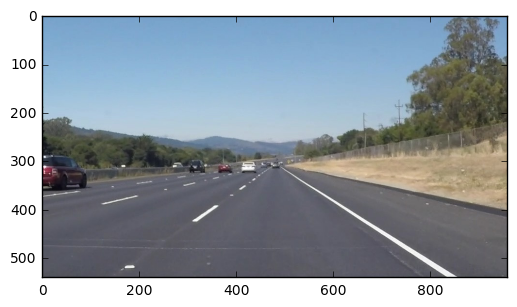

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def filter_lines(lines, imshape, 
                 angle_min_mag = 25*pi/180, angle_max_mag = 40*pi/180, 
                 rho_min_diag = 0.05, rho_max_diag = 0.75):
    diag_len = math.sqrt(imshape[0]**2 + imshape[1]**2)
    
    out_lines = []
    for line in lines:
        out_line = []
        for x1,y1,x2,y2 in line:
            # x1*cos(theta) + y1*sin(theta) = rho
            # x2*cos(theta) + y2*sin(theta) = rho
            # ((x1+x2)*cos(theta) + (y1+y2)*sin(theta))/2. = rho
            theta = math.atan2(x2-x1, y2-y1) - pi/2
            rho = ((x1+x2)*math.cos(theta) + (y1+y2)*math.sin(theta))/2
            if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag
                and rho >= rho_min_diag*diag_len and rho <= rho_max_diag*diag_len):
                out_line.append((x1,y1,x2,y2))
                
        if len(out_line) > 0:
            out_lines.append(out_line)
                
    return out_lines

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_lines(lines, imshape, color=[255, 0, 0], thickness=10):
    """
    Create an OpenCV image of size `imshape` and draw the lines specified by `lines`
    
    `lines` is the output of hough_lines
    `imshape` is a tuple representing the shape of the image

    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    if len(imshape) < 3:
        imshape = (imshape[0], imshape[1], 3)
    else:
        imshape = imshape

    line_img = np.zeros(imshape, dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    return line_img

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidYellowLowContrast.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

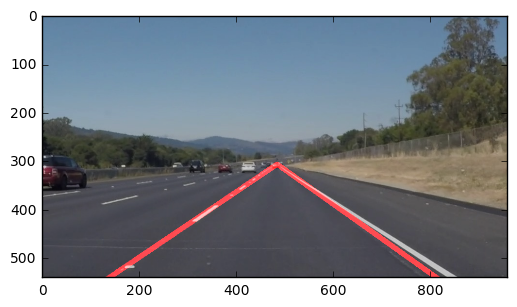

In [7]:
def detect_lanes(lines, imshape,
                angle_min_mag = 30*pi/180, angle_max_mag = 40*pi/180, 
                rho_min_diag = 0.10, rho_max_diag = 0.7, last_lanes = None):
    
    lane_markers_x = [[], []]
    lane_markers_y = [[], []]
    
    if last_lanes is not None:
        last_int_pt = np.array([last_lanes[0][0][2], last_lanes[0][0][3]])
        last_left_pt = last_lanes[0][0][1]
        last_right_pt = last_lanes[1][0][1]    
    
    diag_len = math.sqrt(imshape[0]**2 + imshape[1]**2)
    for line in lines:
        for x1,y1,x2,y2 in line:
            theta = math.atan2(y1-y2, x2-x1)
            rho = ((x1+x2)*math.cos(theta) + (y1+y2)*math.sin(theta))/2
            
            if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag
                and rho >= rho_min_diag*diag_len and rho <= rho_max_diag*diag_len):

                if theta > 0: # positive theta is downward in image space?
                    # Left lane marker
                    i = 0
                else:
                    # Right lane marker
                    i = 1
                lane_markers_x[i].append(x1)
                lane_markers_x[i].append(x2)
                lane_markers_y[i].append(y1)
                lane_markers_y[i].append(y2)

    if (len(lane_markers_x[0]) == 0 or
        len(lane_markers_x[1]) == 0 or
        len(lane_markers_y[0]) == 0 or
        len(lane_markers_y[1]) == 0):
        
        # Use cached value if available if detection failed
        if last_lanes is not None:
            int_pt = last_int_pt
            left_pt = last_left_pt
            right_pt = last_right_pt
        else:
            return None
    else:
        # Least Squares fit
        p_left  = np.polyfit(lane_markers_x[0], lane_markers_y[0], 1)
        p_right = np.polyfit(lane_markers_x[1], lane_markers_y[1], 1)
        
        # Find intersection
        int_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
        left_pt = math.ceil(np.polyval(p_left, 0))
        right_pt = math.ceil(np.polyval(p_right, imshape[1]))
        

        if last_lanes is not None:
            if math.sqrt((int_pt[0] - last_int_pt[0])**2 + 
                         (int_pt[1] - last_int_pt[1])**2) > 0.2*diag_len:
                int_pt[0] = math.ceil(0.9*last_int_pt[0] + 0.1*int_pt[0])
                int_pt[1] = math.ceil(0.9*last_int_pt[0] + 0.1*int_pt[1])
                
            if abs(left_pt - last_left_pt) > 0.05*diag_len:
                left_pt = math.ceil(last_left_pt*0.5 + left_pt*0.5)
#             else:
#                 left_pt = math.ceil(last_left_pt*0.7 + left_pt*0.3)
                
            if abs(right_pt - last_right_pt) > 0.05*diag_len:
                right_pt = math.ceil(last_right_pt*0.5 + right_pt*0.5)
#             else:
#                 right_pt = math.ceil(last_right_pt*0.7 + right_pt*0.3)
    
    return [[(0, left_pt, int(int_pt[0]), int(int_pt[1]))],
            [(imshape[1], right_pt, int(int_pt[0]), int(int_pt[1]))]]

def process_image(image, 
                  bounds=None, 
                  gauss_size=5,
                  canny_low=50, canny_high=150, use_cache=False):
    
    if not use_cache:
        process_image.last_lanes = None
    
    gray_img = grayscale(image)

    # Auto-Level image for dealing with low-contrast frames    
    # Ref: http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    gray_eq_img = cv2.equalizeHist(gray_img)

    gray_img = gray_eq_img
    blur_gray = gaussian_noise(gray_img, kernel_size=gauss_size)
    
    # Define our parameters for Canny and apply
    edges = canny(blur_gray, canny_low, canny_high)
    
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    # Define trapezoid as fraction of image dimensions
    if bounds is None:
        bounds = {'bl':(0.00,  1.00),  # Bottom left
                  'tl':(0.495, 0.58),  # Top left
                  'tr':(0.505, 0.58),  # Top right
                  'br':(1.00,  1.00)}   # Bottom right
        
    # Define bounding polygon based on specified bounds
    vertices = np.array([[(imshape[1]*bounds['bl'][0], imshape[0]*bounds['bl'][1]),
                          (imshape[1]*bounds['tl'][0], imshape[0]*bounds['tl'][1]),
                          (imshape[1]*bounds['tr'][0], imshape[0]*bounds['tr'][1]),
                          (imshape[1]*bounds['br'][0], imshape[0]*bounds['br'][1])]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    rho = 2              # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 15       # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 # minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    if lines is not None:
        lanes = detect_lanes(lines, imshape, last_lanes=process_image.last_lanes)
        
        if use_cache:
            process_image.last_lanes = lanes
            
        if lanes is not None:
            line_img = draw_lines(lanes, imshape)
        else:
            line_img = draw_lines([[]], imshape)
        # Draw lines on original image
        result = weighted_img(line_img, image)
    else:
        result = image

    return result
process_image.last_lanes = None

config = dict(bounds = {'bl':(0.20, 0.90),  # Bottom left
                        'tl':(0.495, 0.6),  # Top left
                        'tr':(0.505, 0.6),  # Top right
                        'br':(1.00, 0.90)}, # Bottom right
              canny_low=75,
              canny_high=150,
              gauss_size=5,
              use_cache=False)

image = mpimg.imread('test_images/solidWhiteRight.jpg')
# image = mpimg.imread('test_images/solidYellowLowContrast.jpg')
im1 = process_image(image, **config)
plt.figure()
plt.imshow(im1)

In [ ]:
# Process all test images
# os.mkdir('output_images/')

for img_name in os.listdir("test_images/"):
    image = mpimg.imread('test_images/'+img_name)
    processed_img = process_image(image, use_cache=False)
    plt.figure()
    plt.imshow(processed_img)
    mpimg.imsave('output_images/'+img_name, processed_img)

Let's try the one with the solid white lane on the right first ...

In [18]:
config['use_cache'] = True
config['canny_low'] = 75
config['gauss_size'] = 5
config['bounds'] = {'bl':(0.15, 0.90),  # Bottom left
                    'tl':(0.495, 0.60),  # Top left
                    'tr':(0.505, 0.60),  # Top right
                    'br':(0.85, 0.90)}  # Bottom right

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(lambda i: process_image(i, **config))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 31.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.4 s, sys: 1.09 s, total: 4.5 s
Wall time: 8.11 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls="true">
  <source src="{0}" type="video/mp4">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
config['use_cache'] = True
config['canny_low'] = 50
config['gauss_size'] = 5
config['bounds'] = {'bl':(0.10, 0.90),  # Bottom left
                    'tl':(0.495, 0.60),  # Top left
                    'tr':(0.505, 0.60),  # Top right
                    'br':(0.90, 0.90)}  # Bottom right

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lambda i: process_image(i, **config))
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:30<00:00, 26.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 16.7 s, sys: 2.64 s, total: 19.4 s
Wall time: 31.6 s


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections
### Overview of the Image Pipeline

The lane detection algorithm builds upon the hough-transform method described in the lessons. I added in some extra features, along with some averaging to get over small gaps in the data. The steps in the algorithm are as follows:

1. Convert the image to grayscale using the `grayscale` function.
2. Perform a histogram equalization operation to adjust for different lighting levels by improving contrast. This is similar to the "Auto-level" functionality in Photoshop. OpenCV's `equalizeHist` function was used as described [here](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html). The CLAHE (Contrast Limited Adaptive Histogram Equalization) algorithm was also considered but performed worse than `equalizeHist` probably due to bad configuration parameters.
3. Call `gaussian_noise` and `canny_edge` to add some blurring to the image and detect the edges. The parameters that go into these functions, namely `kernel_size`, and the threshold values were added as configurable parameters to `process_images` so that they can be easily adjusted for different data sources.
4. The region of interest is extracted of the image (resulting from edge detection) using the `region_of_interest` method by masking out the rest of the image. The bounds of the region are defined by a `bounds` parameter to the `process_images` method. The bounds are defined in the format shown below. The vertices are specified in normalized image coordinates so that they are agnostic to the actual dimensions of the image. `bounds` should be tuned to account for the position and pose of the camera. For example, it is used to avoid the reflection from the car's hood in the "challenge" video. 
```python
bounds = {'bl':(0.20, 0.90),  # Bottom left
          'tl':(0.495, 0.6),  # Top left
          'tr':(0.505, 0.6),  # Top right
          'br':(0.95, 0.90)}, # Bottom right
```
5. The `hough_lines` method is called to detect the lines in the image. The method was modified so that it only returns the coordinates of the lines rather than also drawing them on the image. This is to make sure that only the detected lane markers are shown in the output. As of now, the parameters relating to the Hough transform are hard-coded into the function. This can also be made configurable if needed. 

6. The `detect_lanes` method is called to detect the actual lane markers from the line segments detected using the Hough transform. This method is described in detail in the next section. The output of `detect_lanes` is cached if the `use_cache` parameter is set to True. This is used in smooth out jitters and increase robustness of the lane detection algorithm.

7. The left and right lane marker coordinates returned by `detect_lanes` is overlayed on the original frame using the `draw_lines` method.



### Lane Detection Algorithm

The work of actually detecting lanes out of all the line segments detected by the Hough transform is performed in the `detect_lanes` method. This section will be a line-by-line walkthrough of the method.

```python
def detect_lanes(lines, imshape,
                angle_min_mag = 30*pi/180, angle_max_mag = 40*pi/180, 
                rho_min_diag = 0.10, rho_max_diag = 0.7, last_lanes = None)
```

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')

## Define custom bounding box for new camera setup in challenge
config = dict(bounds = {'bl':(0.20, 0.90),  # Bottom left
                        'tl':(0.495, 0.6),  # Top left
                        'tr':(0.505, 0.6),  # Top right
                        'br':(0.95, 0.90)}, # Bottom right
              canny_low=75,
              canny_high=150,
              gauss_size=7,
              use_cache=True)

challenge_clip = clip2.fl_image(lambda img: process_image(img, **config))
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:16<00:00, 15.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.02 s, sys: 1.94 s, total: 8.97 s
Wall time: 18.3 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))